# Compare UMI cutoffs 2k vs 5k

In [1]:
# %load ../config/defaults.py
# Imports
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix


# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb, Seurat
from larval_gonad.plotting import make_figs, plot_confusion_matrix
from larval_gonad.config import memory

# Setup notebook
nbconfig = Nb.setup_notebook('2018-03-22_compare_testis_2k_to_5k_umi')

last updated: 2018-03-26 
Git hash: 0e78dce8413b08a6852759bfce844a9f30437ed8


In [2]:
mpl.style.use(['common', 'talk'])

In [4]:
res = 'res.1.2'

In [5]:
s2k = Seurat('../output/testis1_scRNAseq_umi_2k_and_5k/2k')
s5k = Seurat('../output/testis1_scRNAseq_umi_2k_and_5k/5k')

In [6]:
var_genes_2k = set(s2k.get_var_genes())
var_genes_5k = set(s5k.get_var_genes())
var_genes = list(var_genes_2k.intersection(var_genes_5k))

In [7]:
norm2k = s2k.get_normalized_read_counts().query(f'FBgn in {var_genes}')
norm5k = s5k.get_normalized_read_counts().query(f'FBgn in {var_genes}')

In [8]:
X2k = norm2k.T.values
X5k = norm5k.T.values

In [9]:
Y2k = s2k.get_metadata().loc[norm2k.columns, res]
Y5k = s5k.get_metadata().loc[norm5k.columns, res]

In [10]:
scaler = StandardScaler().fit(X2k)
X2k_std = scaler.transform(X2k)
X5k_std = scaler.transform(X5k)

In [11]:
pca = PCA(n_components=30).fit(X2k_std)
X2k_reduced = pca.transform(X2k_std)
X5k_reduced = pca.transform(X5k_std)

In [12]:
svm = SVC().fit(X2k_reduced, Y2k.values)
Y5k_pred = svm.predict(X5k_reduced)

In [13]:
cm = confusion_matrix(Y5k.values, Y5k_pred)

Text(0.5,1,'UMI Cutoff: 5000')

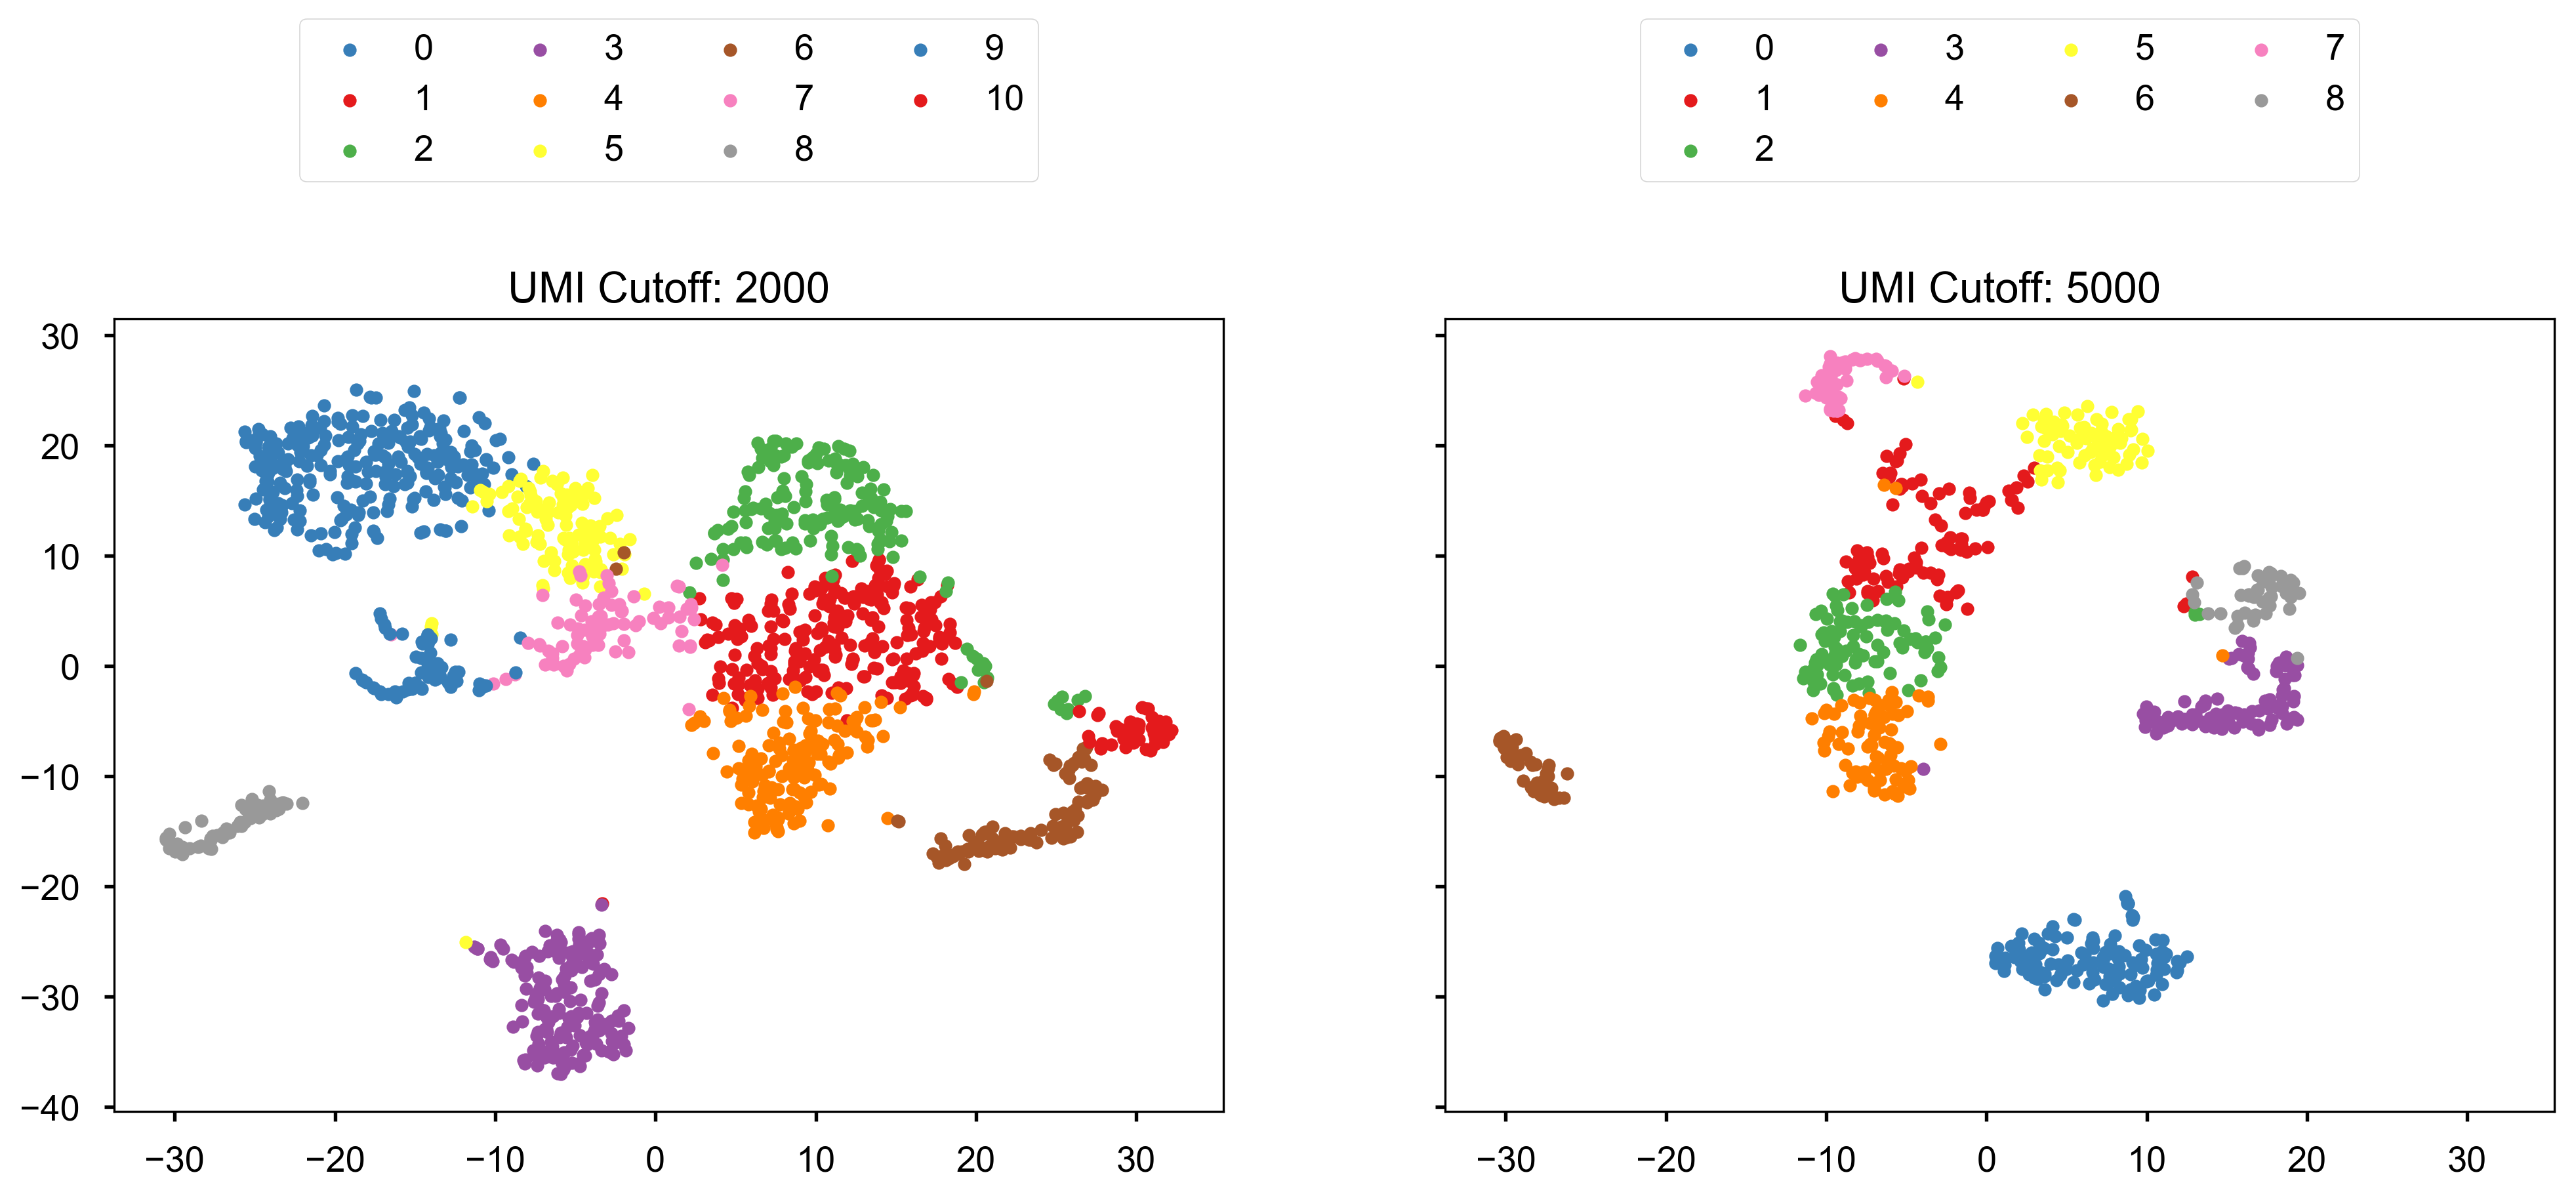

In [25]:
tsne2k = s2k.get_tsne().join(Y2k)
tsne5k = s5k.get_tsne().join(Y5k)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(1/3), sharex=True, sharey=True)

for i, dat in tsne2k.groupby(res):
    ax1.scatter(dat.tSNE_1, dat.tSNE_2, label=i, s=20)
ax1.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.4))
ax1.set_title('UMI Cutoff: 2000')
    
for i, dat in tsne5k.groupby(res):
    ax2.scatter(dat.tSNE_1, dat.tSNE_2, label=i, s=20)
ax2.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.4))
ax2.set_title('UMI Cutoff: 5000')

Confusion matrix, without normalization


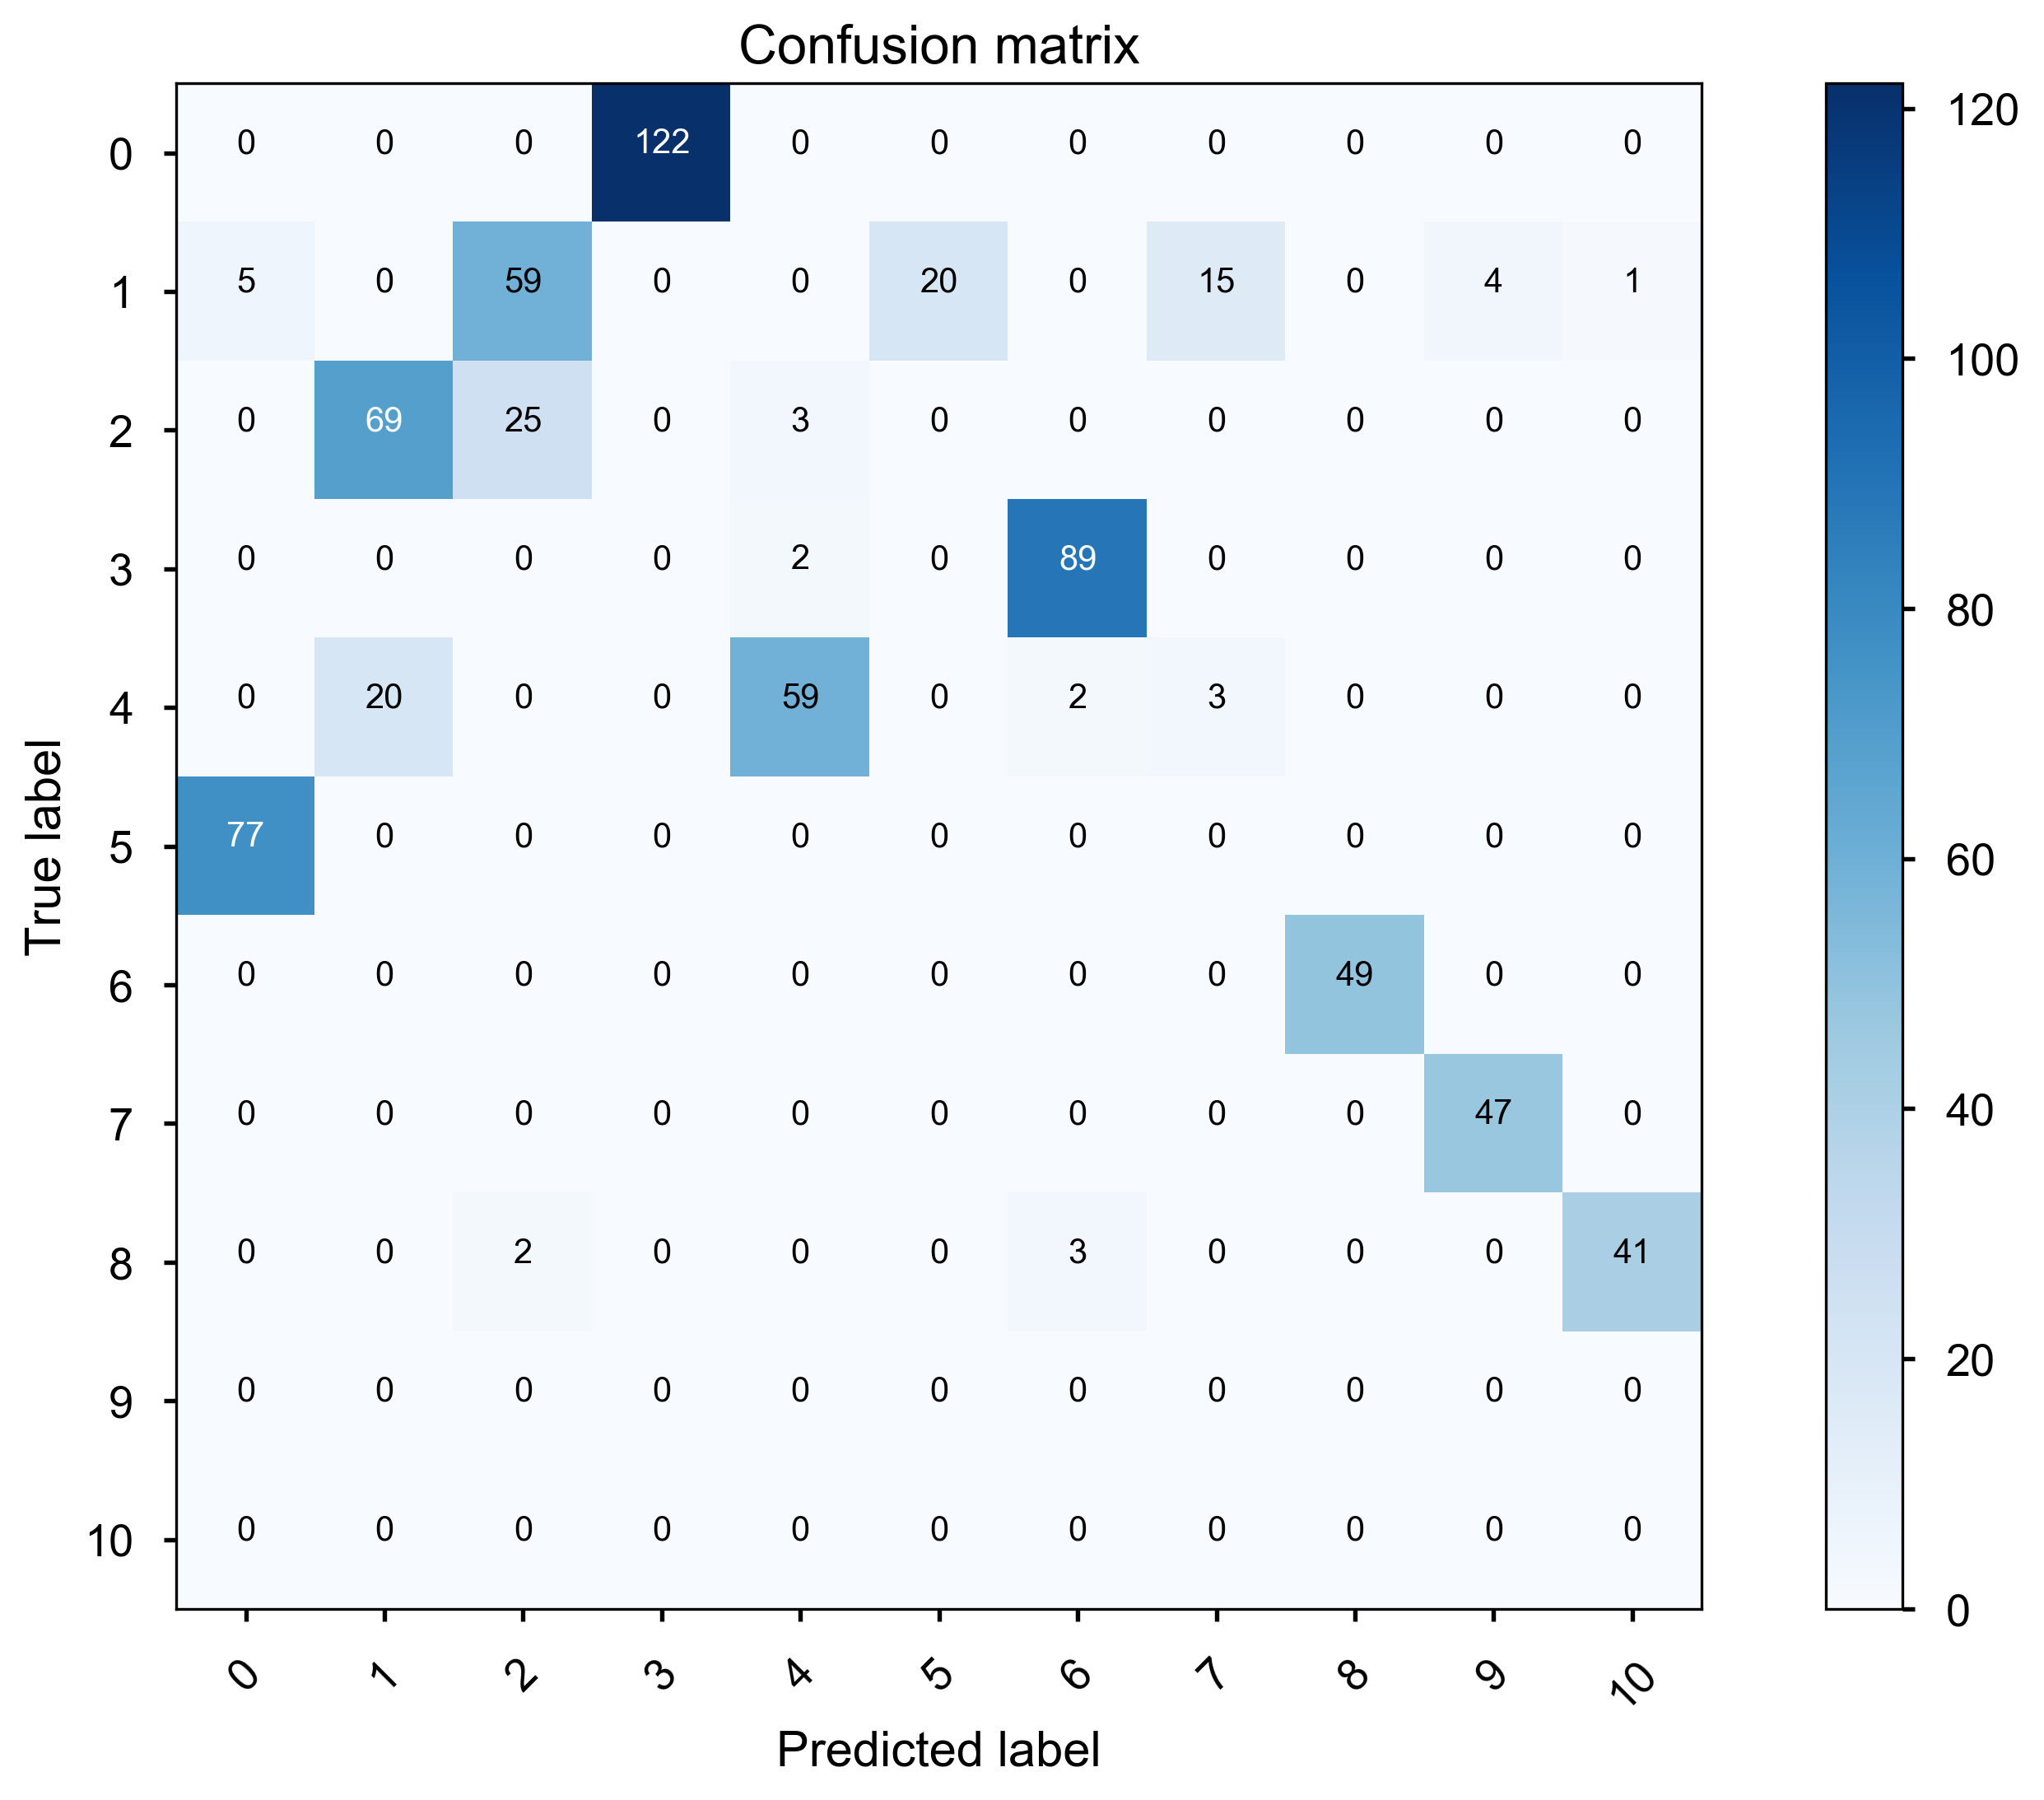

In [21]:
plot_confusion_matrix(cm, np.unique(Y5k_pred))

In [51]:
Same = pd.concat([Y2k, Y5k], axis=1, join='inner')

In [65]:
Same.shape

(717, 2)

In [53]:
cm2 = confusion_matrix(Same.iloc[:, 0], Same.iloc[:, 1])

Confusion matrix, without normalization


Text(575.508,0.5,'2k KNN Labels')

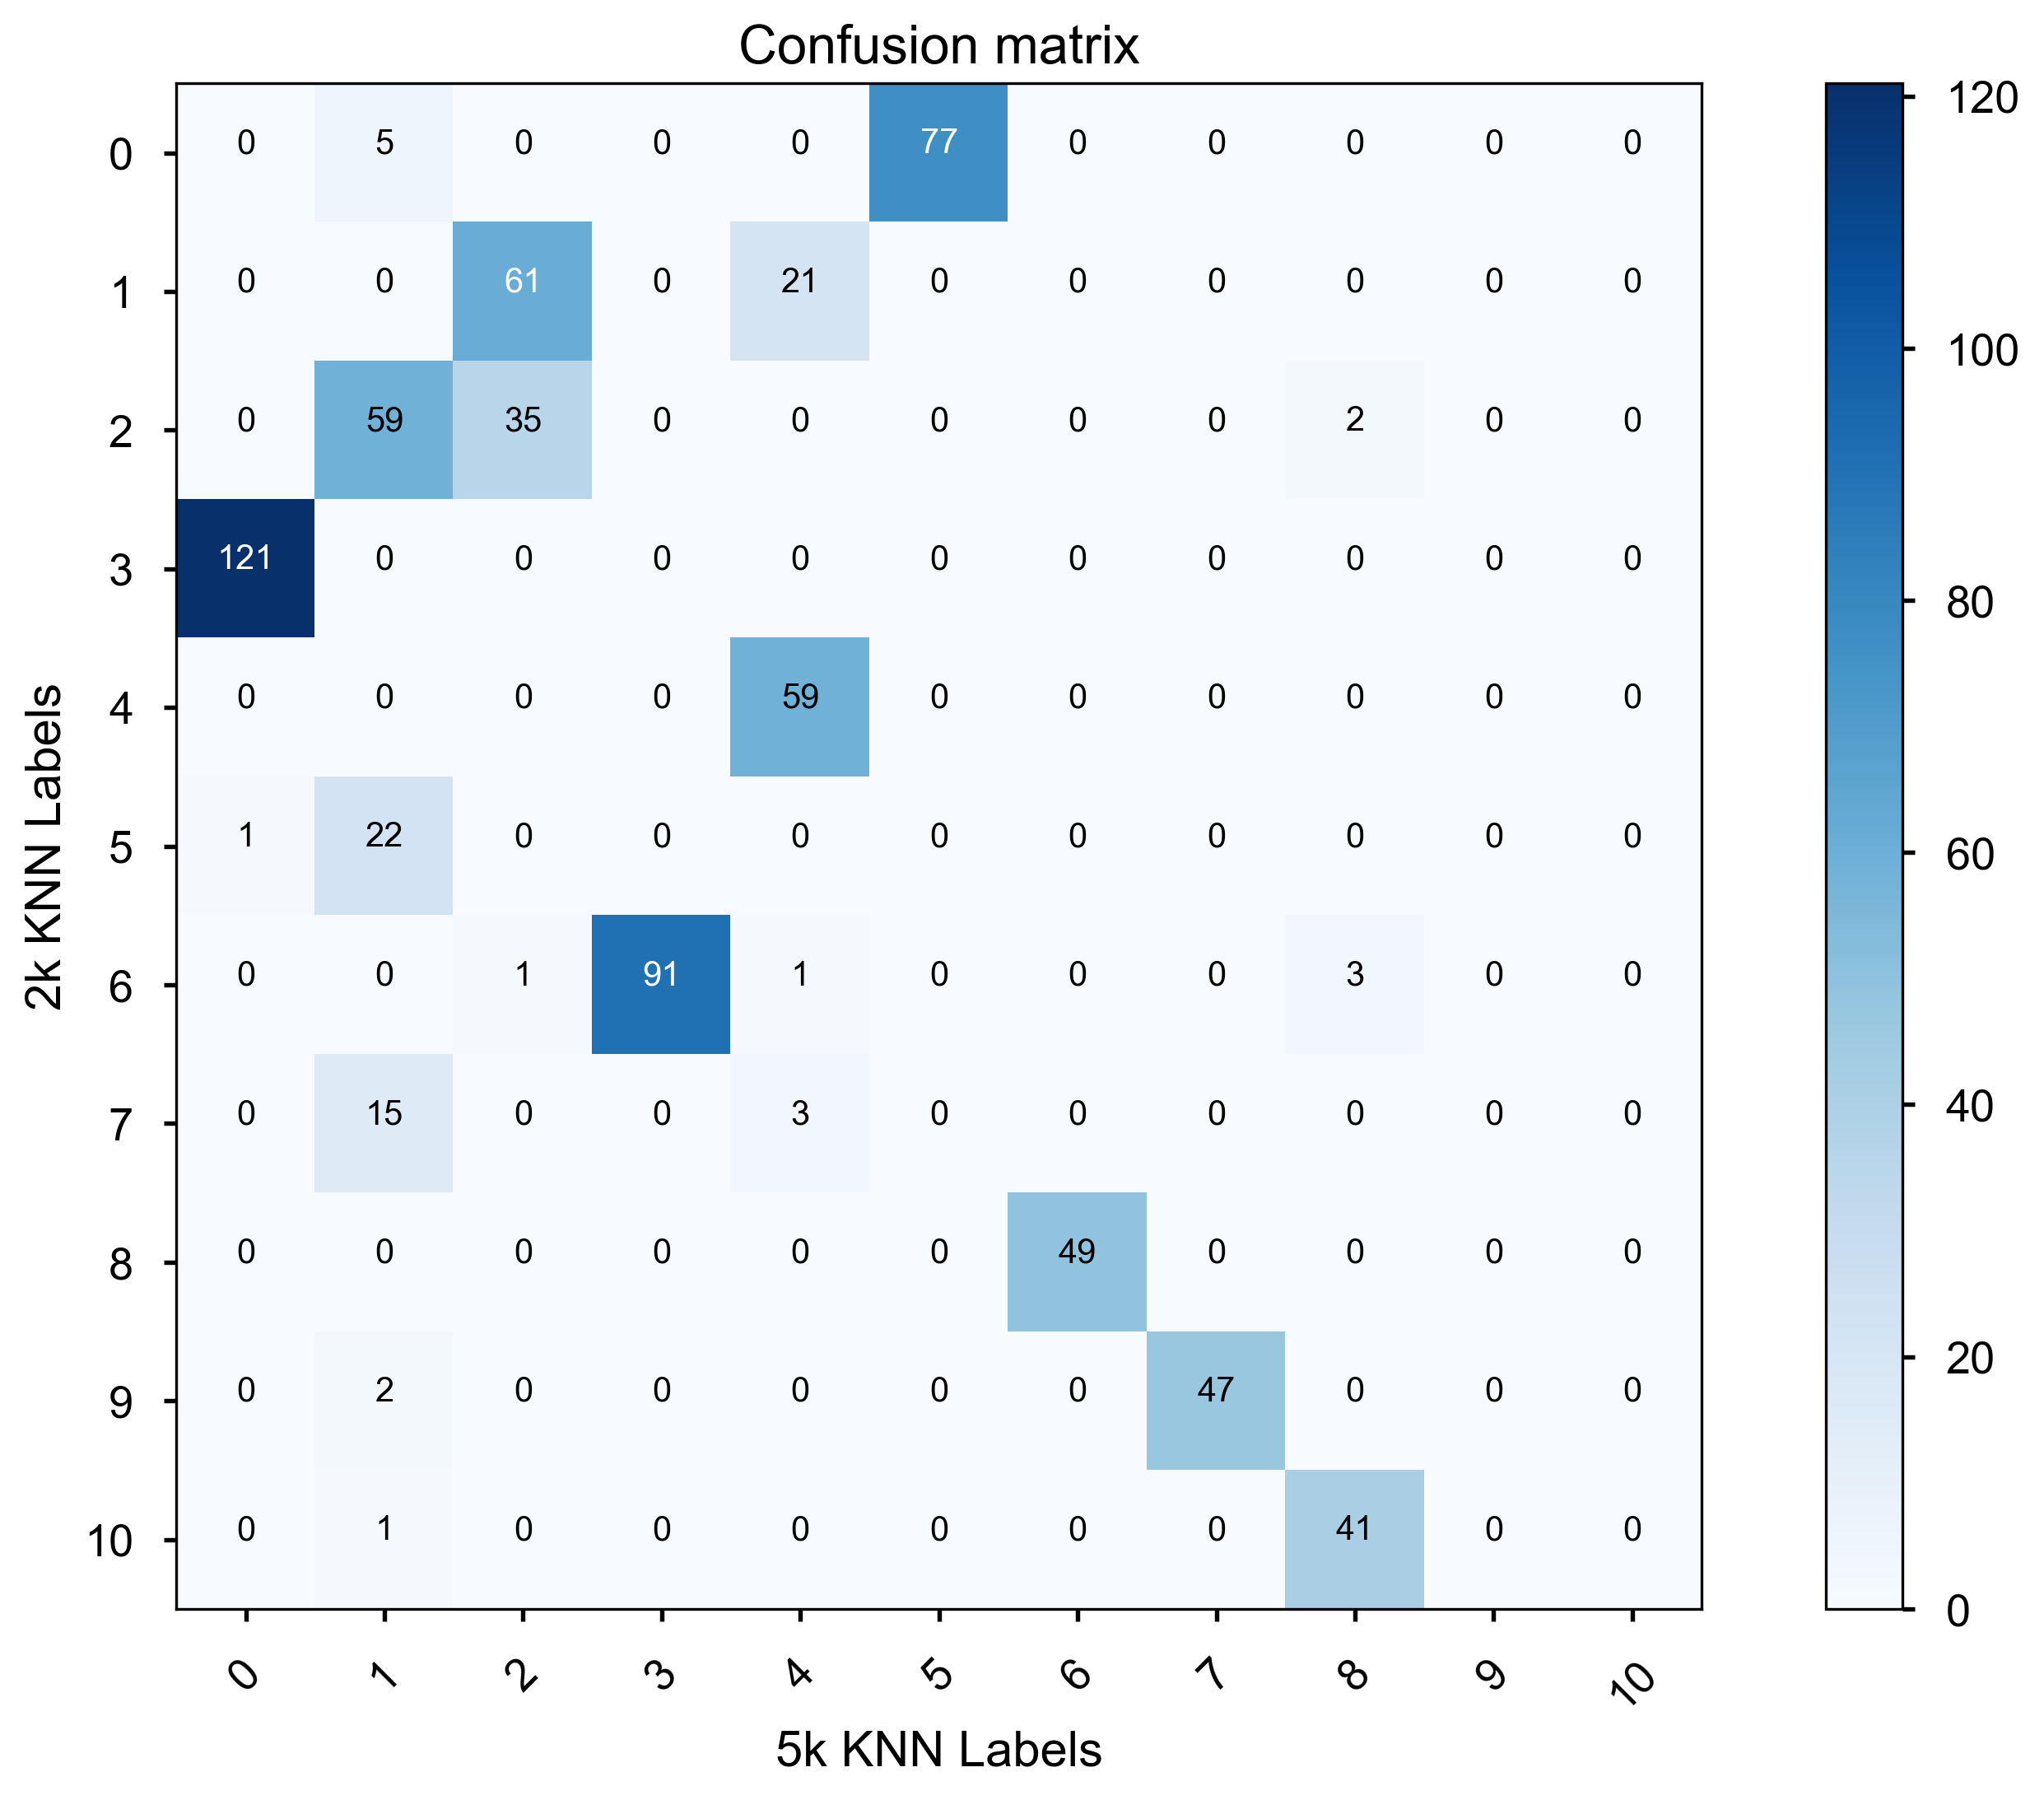

In [60]:
plot_confusion_matrix(cm2, sorted(Same.iloc[:, 0].unique()))
ax = plt.gca()
ax.set_xlabel('5k KNN Labels')
ax.set_ylabel('2k KNN Labels')

In [22]:
from sklearn.cluster import KMeans

In [71]:
km = KMeans(n_clusters=11)

In [72]:
Ykm2k = km.fit_predict(X2k_reduced)
Ykm2k = pd.DataFrame(Ykm2k, index=norm2k.T.index)
Ykm2k.columns = ['res']

Ykm5k = km.fit_predict(X5k_reduced)
Ykm5k = pd.DataFrame(Ykm5k, index=norm5k.T.index)
Ykm5k.columns = ['res']

Text(0.5,1,'UMI Cutoff: 5000')

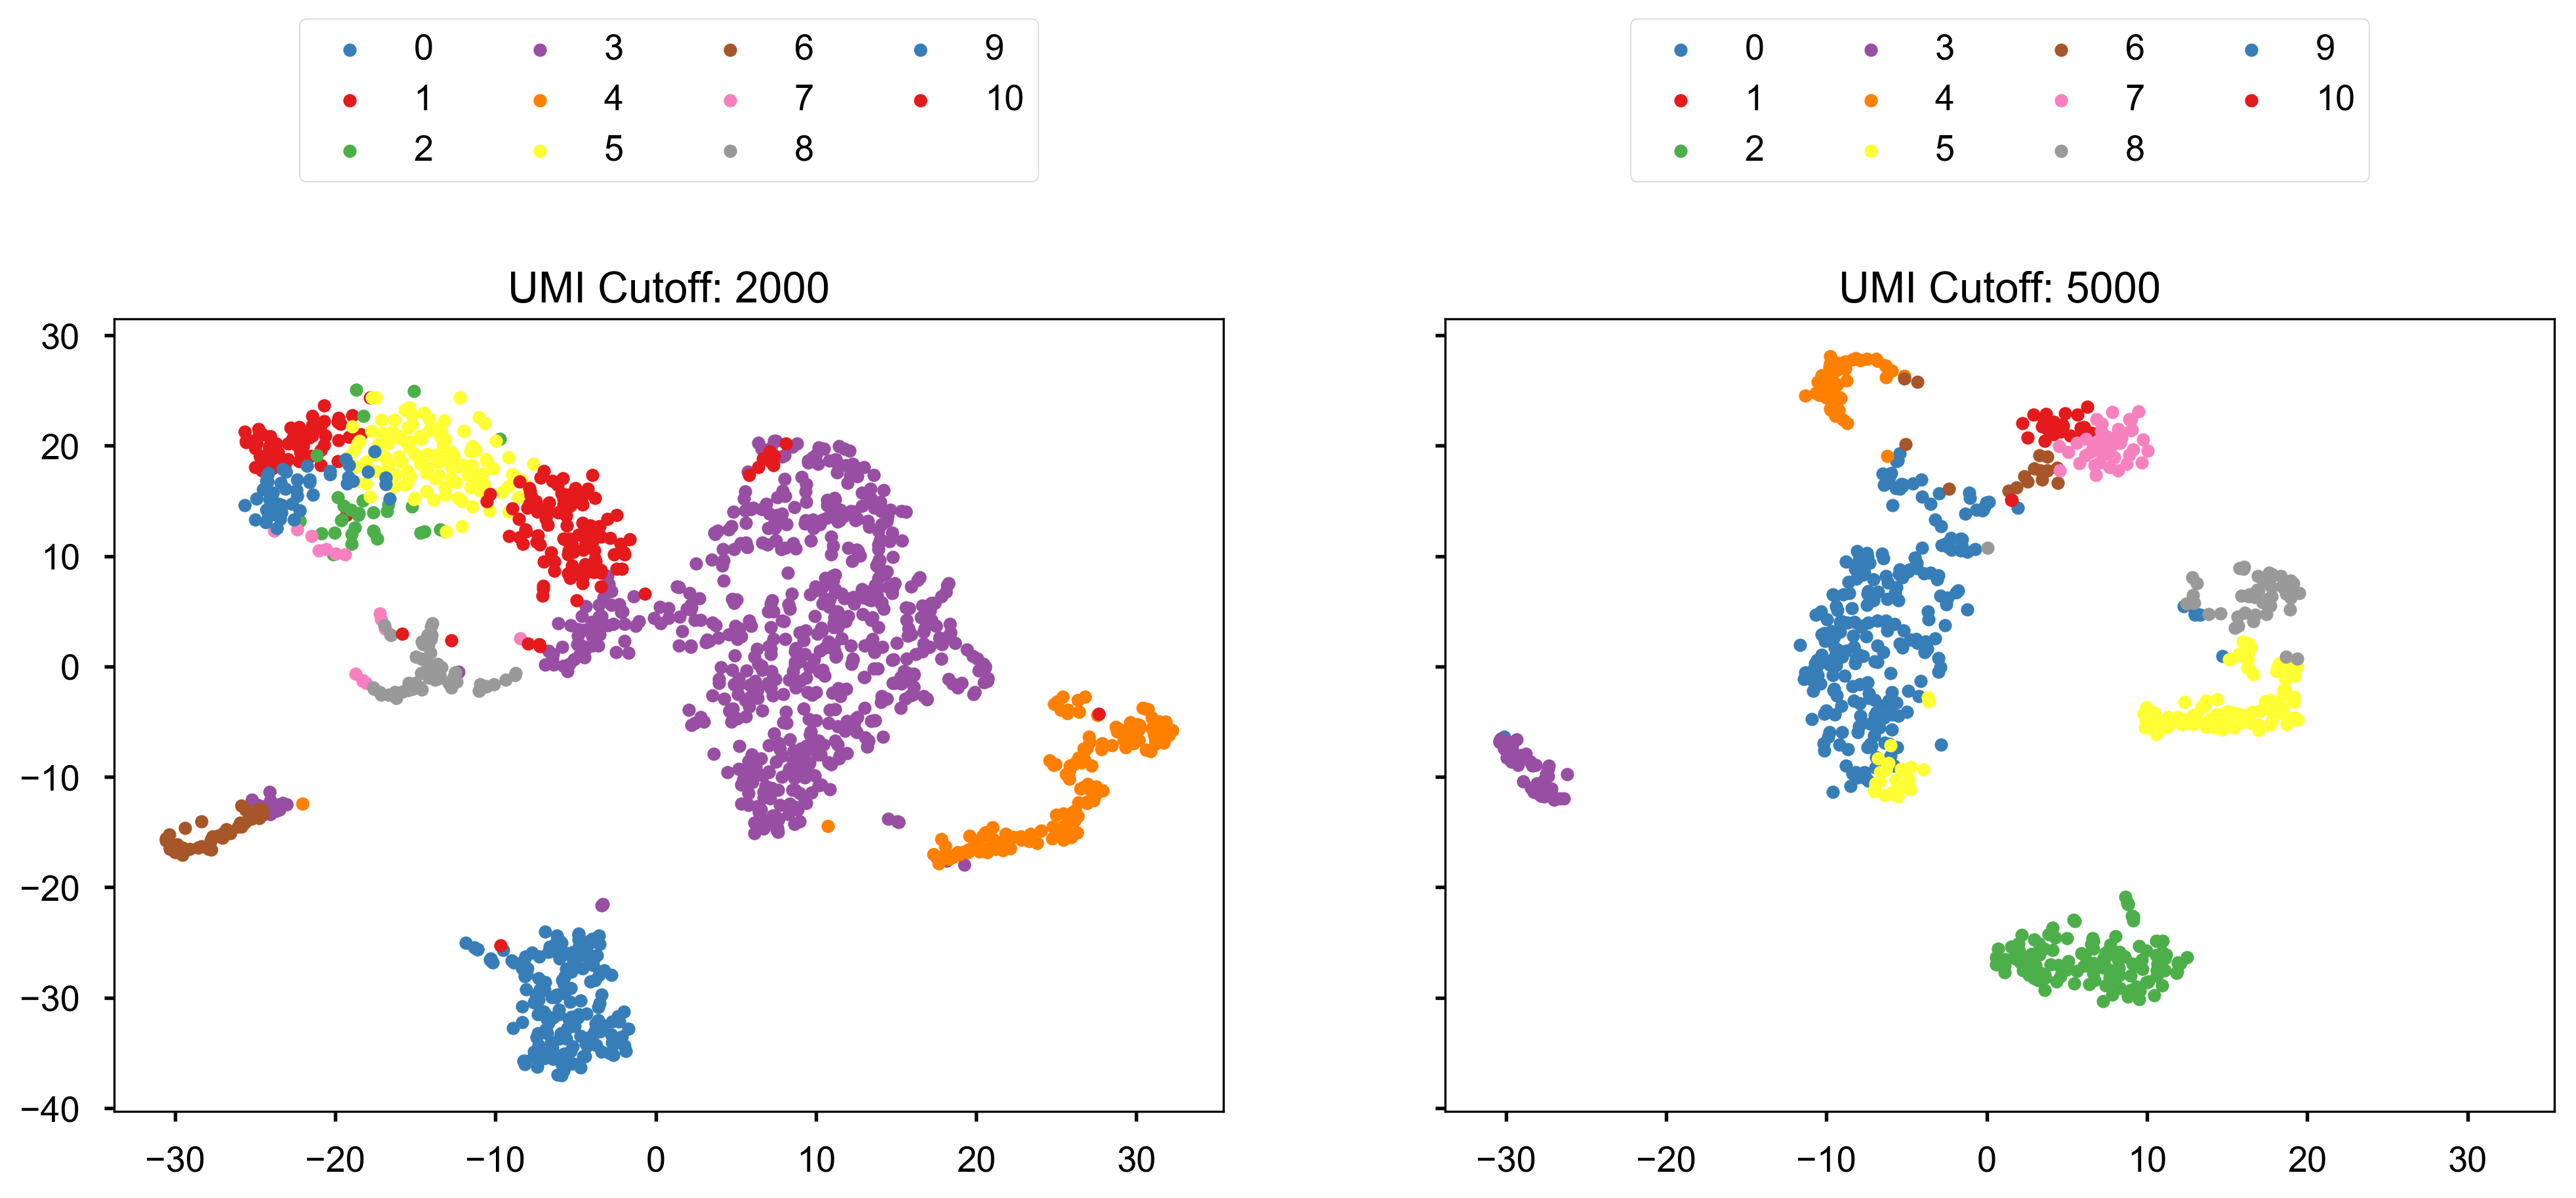

In [73]:
tsne2k = s2k.get_tsne().join(Ykm2k)
tsne5k = s5k.get_tsne().join(Ykm5k)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(1/3), sharex=True, sharey=True)

for i, dat in tsne2k.groupby('res'):
    ax1.scatter(dat.tSNE_1, dat.tSNE_2, label=i, s=20)
ax1.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.4))
ax1.set_title('UMI Cutoff: 2000')
    
for i, dat in tsne5k.groupby('res'):
    ax2.scatter(dat.tSNE_1, dat.tSNE_2, label=i, s=20)
ax2.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.4))
ax2.set_title('UMI Cutoff: 5000')

In [74]:
kmSame = Ykm2k.join(Ykm5k, lsuffix='2k', rsuffix='5k', how='inner')

In [75]:
kmSame.shape

(717, 2)

In [76]:
cmKM = confusion_matrix(kmSame.iloc[:, 0], kmSame.iloc[:, 1])

Confusion matrix, without normalization


Text(0.5,121,'5k Kmeans')

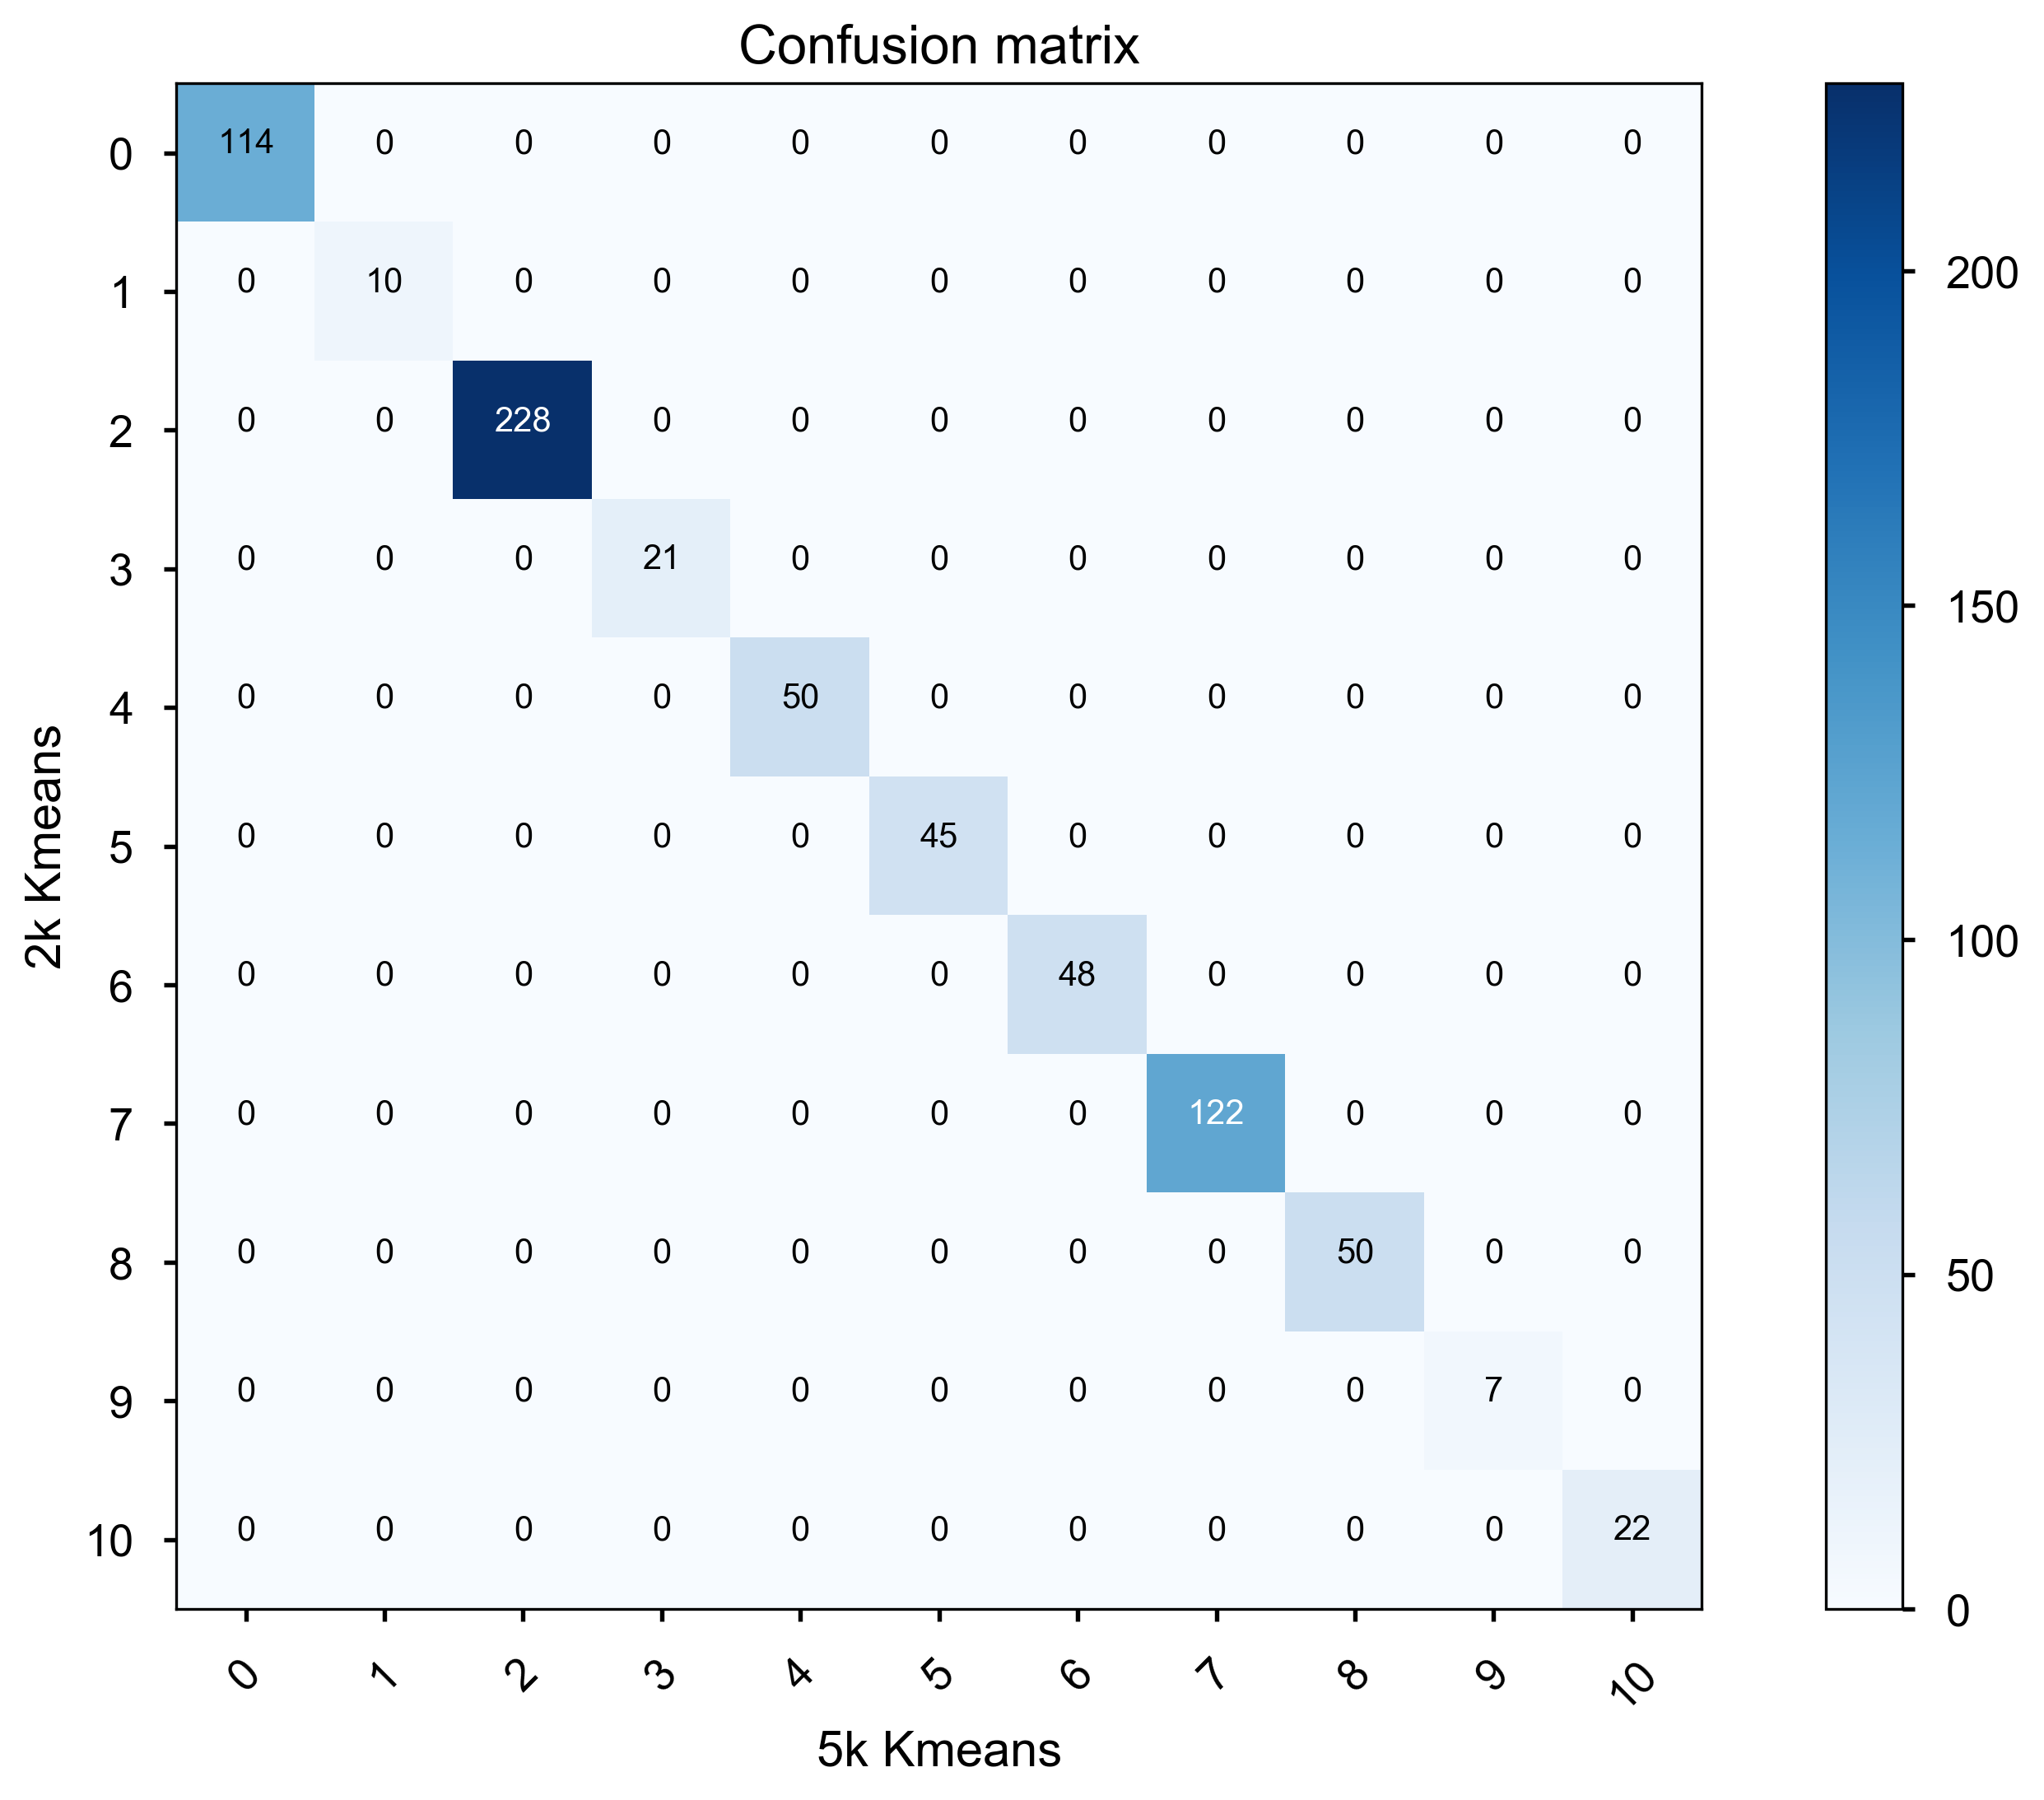

In [63]:
plot_confusion_matrix(cmKM, sorted(kmSame.res2k.unique()))
ax = plt.gca()
ax.set_ylabel('2k Kmeans')
ax.set_xlabel('5k Kmeans')